In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
torch.cuda.set_device(0)
from fastai import *
from fastai.text import *
from pathlib import Path
import pickle
import fastText as ft
from collections import defaultdict

In [3]:
PATH=Path('/mnt/data/extracts/translate')
DATA=PATH/'data/'
TMP=PATH/'tmp/'
TMP.mkdir(exist_ok=True)
MODELS=Path('/mnt/models/translate')

## Load Data

In [4]:
qs = pickle.load((DATA/'fr-en-qs.pkl').open('rb'))
en_qs, fr_qs = zip(*qs)

In [5]:
en_tok = pickle.load((DATA/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((DATA/'fr_tok.pkl').open('rb'))

In [30]:
def tok2ids(tok, lim=40000):
    flat = [w for l in tok for w in l]
    toi = Counter(flat).most_common(lim)
    itos = [o for o, c in toi]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = {t:i for i, t in enumerate(itos)}
    ids = [([stoi[t] for t in q] + [2]) for q in tok]
    return ids, itos, stoi

In [7]:
fr_ids, fr_itos, fr_stoi = tok2ids(fr_tok)
en_ids, en_itos, en_stoi = tok2ids(en_tok)

## Load Embeddings

In [194]:
en_ft = ft.load_model(str((DATA/'wiki.en.bin')))
fr_ft = ft.load_model(str((DATA/'wiki.fr.bin')))

def get_vecs(ftxt):
    return {w: ftxt.get_word_vector(w) for w in ftxt.get_words()}

en_vecs = get_vecs(en_ft)
fr_vecs = get_vecs(fr_ft)

In [8]:
en_vecs = pickle.load(open(DATA/'wiki.en.pkl','rb'))
fr_vecs = pickle.load(open(DATA/'wiki.fr.pkl','rb'))

## Create Data Loaders

In [9]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): 
        super(Seq2SeqDataset, self).__init__()
        self.x = x
        self.y = y
        
    def __getitem__(self, i):
        return A(self.x[i], self.y[i])
        
    def __len__(self):
        return len(self.x)

In [10]:
en_cutoff = int(np.percentile([len(q) for q in en_ids], q=97))
fr_cutoff = int(np.percentile([len(q) for q in fr_ids], q=95))

In [11]:
en_arr = np.array([q[:en_cutoff] for q in en_ids])
fr_arr = np.array([q[:fr_cutoff] for q in fr_ids])

In [17]:
np.random.seed(42)
val_idx = np.random.rand(len(en_arr)) <= 0.1
en_tr, fr_tr = en_arr[~val_idx], fr_arr[~val_idx]
en_val, fr_val = en_arr[val_idx], fr_arr[val_idx]

In [19]:
trn_ds = Seq2SeqDataset(fr_tr, en_tr)
val_ds = Seq2SeqDataset(fr_val, en_val)

In [20]:
bs = 125
tr_samp = SortishSampler(en_tr, key=lambda x: len(en_tr[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [21]:
trn_dl = DataLoader(trn_ds, batch_size=bs, sampler=tr_samp, transpose=True, transpose_y=True,
                    pre_pad=False, pad_idx=1, num_workers=1)
val_dl = DataLoader(val_ds, batch_size=bs, sampler=val_samp, transpose=True, transpose_y=True, 
                   pre_pad=False, pad_idx=1, num_workers=1)
md = ModelData(TMP, trn_dl, val_dl)

In [22]:
len(fr_itos)

24793

## Create Seq2SeqRNN

In [23]:
def create_embedding(itos, ft_vecs):
    vs = len(itos)
    emb_sz = list(en_vecs.values())[0].shape[0]
    miss = []
    emb = nn.Embedding(vs, emb_sz)
    wgt = emb.weight.data
    for i, w in enumerate(itos):
        try:
            wgt[i] = torch.from_numpy(ft_vecs[w]*3)
        except KeyError:
            miss.append(w)
    print(len(miss))
    return emb

In [37]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, en_itos, fr_itos, enc_hidden, en_cutoff, nl=2):
        super(Seq2SeqRNN, self).__init__()
        en_vs = len(en_itos)
        fr_vs = len(fr_itos)
        emb_sz = list(en_vecs.values())[0].shape[0]
        self.enc_emb = create_embedding(fr_itos, fr_vecs)
        self.enc_drop = nn.Dropout(0.15)
        self.enc_gru = nn.GRU(emb_sz, enc_hidden, num_layers=nl, dropout=0.25)
        self.enc_out = nn.Linear(enc_hidden, emb_sz, bias=False)
        
        self.dec_emb = create_embedding(en_itos, en_vecs)
        self.dec_drop = nn.Dropout(0.15)
        self.dec_gru = nn.GRU(emb_sz, emb_sz, num_layers=nl, dropout=0.25)
        self.out = nn.Linear(emb_sz, en_vs)
        self.out.weight.data = self.dec_emb.weight.data
        
        self.enc_hidden = enc_hidden
        self.en_cutoff = en_cutoff
        self.emb_sz = emb_sz
        
    def forward(self, x):
        seq_len = x.size()[0]
        bs = x.size()[1]
        x = self.enc_emb(x)
        x = self.enc_drop(x)
        enc_out, enc_h = self.enc_gru(x)
        
        dec_h = self.enc_out(enc_h)
        out_char = to_gpu(V(torch.zeros(bs)).long())
        outl = []
        for i in range(en_cutoff):
            dec_inp = self.dec_emb(out_char)
            dec_inp = dec_inp.unsqueeze(0)
            dec_out, dec_h = self.dec_gru(dec_inp, dec_h)
            out = self.out(self.dec_drop(dec_out[-1]))
            outl.append(out)
            out_char = torch.max(out, 1)[-1]
            if np.all(out_char.data.cpu().numpy() == 2):
                break
        return torch.stack(outl)

In [38]:
def cross_loss(inp, tar):
    inp = inp.t()
    tar = tar.t()
    orig_in = inp
    orig_tar = tar
    bs_in, sl_in, nc = inp.size()
    bs_t, sl_t = tar.size()
    if sl_t > sl_in: inp = F.pad(inp, (0, 0, 0, sl_t - sl_in, 0, 0))
    inp = inp[:, :sl_t]
    inp = inp.contiguous().view(-1, nc)
    tar = tar.contiguous().view(-1)
    return F.cross_entropy(inp, tar)

In [39]:
nh = 256
s2s = to_gpu(Seq2SeqRNN(en_itos, fr_itos, nh, en_cutoff))
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(s2s), opt_fn=opt_fn)
learn.crit = cross_loss

3097
1285


 60%|██████    | 219/362 [01:08<00:44,  3.22it/s, loss=30]  

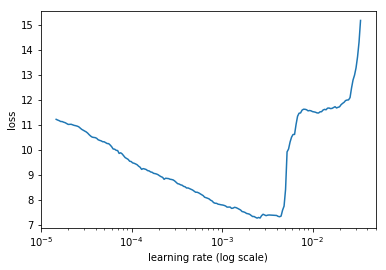

In [27]:
learn.lr_find()
learn.sched.plot()

In [41]:
learn.fit(3e-3, 1, cycle_len=1, use_clr=(20, 10))

epoch      trn_loss   val_loss                              
    0      4.388487   4.709287  



[array([4.70929])]

In [42]:
x,y = next(iter(val_dl))
probs = s2s(V(x))
preds = to_np(probs.max(2)[1])

for i in range(100, 110):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:, i] if o!=1]))
    print()

_bos_ pouvez - vous dire comment votre bagage culturel vous a aidée à aborder votre nouvelle vie au canada ( à vous adapter au mode de vie canadien ) ? _eos_
_bos_ what are some things from your cultural background that have helped you navigate canadian life ( helped you adjust to life in canada ) ? _eos_
_bos_ what do you you you to to to to to to to to to to ? ? ? _eos_ _eos_ ? ? ? _eos_ ? _eos_

_bos_ pour la gestion de crises , pour la défense du territoire , pour la lutte contre les nouvelles menaces terroristes , pour la projection de forces à l' extérieur du
_bos_ where do our interests lie as regards management of crises , defending europe , fighting new terrorist threats , deployment of forces outside europe and armament
_bos_ what is the the the the the the the the the the the and and the ? ? _eos_ _eos_ ? ? ? _eos_ ? _eos_

_bos_ quelles mesures sont prises par les pouvoirs publics assurer la qualité des services sociaux , en particulier les services rendus par les prestatai

## Bidirectional RNN

In [65]:
class Seq2SeqRNN_bidir(nn.Module):
    def __init__(self, en_itos, fr_itos, enc_hidden, en_cutoff, nl=2):
        super(Seq2SeqRNN_bidir, self).__init__()
        en_vs = len(en_itos)
        fr_vs = len(fr_itos)
        emb_sz = list(en_vecs.values())[0].shape[0]
        self.enc_emb = create_embedding(fr_itos, fr_vecs)
        self.enc_drop = nn.Dropout(0.15)
        self.enc_gru = nn.GRU(emb_sz, enc_hidden, num_layers=nl, dropout=0.25, bidirectional=True)
        self.enc_out = nn.Linear(enc_hidden*2, emb_sz, bias=False)
        
        self.dec_emb = create_embedding(en_itos, en_vecs)
        self.dec_drop = nn.Dropout(0.15)
        self.dec_gru = nn.GRU(emb_sz, emb_sz, num_layers=nl, dropout=0.25)
        self.out = nn.Linear(emb_sz, en_vs)
        self.out.weight.data = self.dec_emb.weight.data
        
        self.enc_hidden = enc_hidden
        self.en_cutoff = en_cutoff
        self.emb_sz = emb_sz
        
    def forward(self, x):
        seq_len = x.size()[0]
        bs = x.size()[1]
        x = self.enc_emb(x)
        x = self.enc_drop(x)
        enc_out, enc_h = self.enc_gru(x)
        enc_h = enc_h.view(2, 2, bs, -1).permute(0, 2, 1, 3).contiguous().view(2, bs, -1)
        dec_h = self.enc_out(enc_h)
        out_char = to_gpu(V(torch.zeros(bs)).long()) 
        outl = []
        for i in range(en_cutoff):
            dec_inp = self.dec_emb(out_char)
            dec_inp = dec_inp.unsqueeze(0)
            dec_out, dec_h = self.dec_gru(dec_inp, dec_h)
            out = self.out(self.dec_drop(dec_out[-1]))
            outl.append(out)
            out_char = torch.max(out, 1)[-1]
            if np.all(out_char.data.cpu().numpy() == 2):
                break
        return torch.stack(outl)

In [70]:
s2s_bidir = to_gpu(Seq2SeqRNN_bidir(en_itos, fr_itos, nh, en_cutoff))
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(s2s_bidir), opt_fn=opt_fn)
learn.crit = cross_loss

3097
1285


In [71]:
learn.fit(3e-3, 1, cycle_len=12, use_clr=(20, 10))

epoch      trn_loss   val_loss                              
    0      5.926366   5.641965  
    1      4.277055   4.733568                              
    2      3.918411   4.299195                              
    3      3.585816   4.036121                              
    4      3.309927   3.808351                              
    5      3.10717    3.710067                              
    6      3.135779   3.559877                              
    7      2.814062   3.547565                              
    8      2.744635   3.51729                               
    9      2.560903   3.520077                              
    10     2.297532   3.569727                              
    11     2.258789   3.614478                              



[array([3.61448])]

In [72]:
x,y = next(iter(val_dl))
probs = s2s_bidir(V(x))
preds = to_np(probs.max(2)[1])

for i in range(100, 110):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:, i] if o!=1]))
    print()

_bos_ pouvez - vous dire comment votre bagage culturel vous a aidée à aborder votre nouvelle vie au canada ( à vous adapter au mode de vie canadien ) ? _eos_
_bos_ what are some things from your cultural background that have helped you navigate canadian life ( helped you adjust to life in canada ) ? _eos_
_bos_ what is your personal to your your your to to to your to your to your your to your ? ? ? ? _eos_ _eos_

_bos_ pour la gestion de crises , pour la défense du territoire , pour la lutte contre les nouvelles menaces terroristes , pour la projection de forces à l' extérieur du
_bos_ where do our interests lie as regards management of crises , defending europe , fighting new terrorist threats , deployment of forces outside europe and armament
_bos_ where is the for the security the the the the the the the the the ? ? ? ? _eos_ _eos_

_bos_ quelles mesures sont prises par les pouvoirs publics assurer la qualité des services sociaux , en particulier les services rendus par les prestata